## 练习

1. 在香蕉检测数据集中演示其他带有真实边界框的图像。它们在边界框和目标方面有什么不同？
1. 假设我们想要将数据增强（例如随机裁剪）应用于目标检测。它与图像分类中的有什么不同？提示：如果裁剪的图像只包含物体的一小部分会怎样？

read 1000 training examples


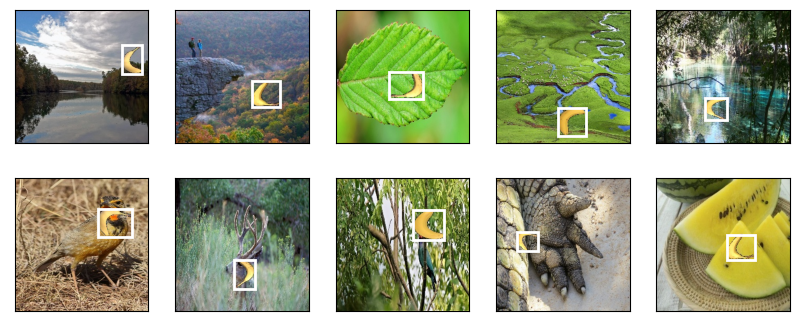

In [3]:
## 练习1
%matplotlib inline
import os
import pandas as pd
import torch
import torchvision
from d2l import torch as d2l

# 下载并提取数据集
d2l.DATA_HUB['banana-detection'] = (
    d2l.DATA_URL + 'banana-detection.zip',
    '5de26c8fce5ccdea9f91267273464dc968d20d72')

# 读取香蕉检测数据集中的图像和标签
def read_data_bananas(is_train=True):
    data_dir = d2l.download_extract('banana-detection')
    csv_fname = os.path.join(data_dir, 'bananas_train' if is_train
                             else 'bananas_val', 'label.csv')
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        images.append(torchvision.io.read_image(
            os.path.join(data_dir, 'bananas_train' if is_train else
                         'bananas_val', 'images', f'{img_name}')))
        targets.append(list(target))
    return images, torch.tensor(targets).unsqueeze(1) / 256

# 定义BananasDataset类
class BananasDataset(torch.utils.data.Dataset):
    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print('read ' + str(len(self.features)) + (f' training examples' if
              is_train else f' validation examples'))

    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx])

    def __len__(self):
        return len(self.features)

# 加载数据集
batch_size, edge_size = 32, 256
train_iter = torch.utils.data.DataLoader(BananasDataset(is_train=True), batch_size, shuffle=True)

# 获取一批数据
batch = next(iter(train_iter))

# 可视化图像和边界框
imgs = (batch[0][0:10].permute(0, 2, 3, 1)) / 255
axes = d2l.show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, batch[1][0:10]):
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])

## 练习2
2. **目标检测中的数据增强与图像分类的区别**:
   
   在目标检测中应用数据增强，比如随机裁剪，需要更加小心，因为它不仅影响图像本身，还影响与图像中的对象相关的边界框。例如，如果裁剪的图像只包含物体的一小部分，那么原始边界框可能不再准确或有意义。

   - 在随机裁剪后，需要调整边界框，以确保它们仍然正确地反映了裁剪图像中物体的位置和尺寸。
   - 如果裁剪的图像中物体的关键部分被移除，或者物体只有很小的一部分被保留，这样的裁剪可能对训练不利，因为它可能不包含足够的信息来正确标识物体。
   - 在进行数据增强时，可能需要应用一定的逻辑来确保生成的新图像和标签仍然是有效和有用的。

   因此，与图像分类相比，目标检测中的数据增强需要更仔细地处理标签信息（如边界框），并确保增强后的数据仍然能够有效地用于训练模型。